# Install Depedencies

In [1]:
# Instal PyTorch dengan dukungan CUDA 12.1
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Instal dependensi lain yang diperlukan
!pip install pandas numpy matplotlib seaborn scikit-learn datasets transformers tabulate

Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Collection

In [2]:
import pandas as pd
import os

# Set the main folder path
main_folder = r'D:\Rap_Gemastik2'

# Load train.csv
train_df = pd.read_csv(os.path.join(main_folder, 'train.csv'))

# Load test.csv
test_df = pd.read_csv(os.path.join(main_folder, 'test.csv'))

# Add full path to filenames (assuming images are in the 'images' subfolder)
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join(main_folder, x))
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.join(main_folder, x))

# Verify if image files exist (optional check)
train_df['exists'] = train_df['filename'].apply(os.path.exists)
test_df['exists'] = test_df['filename'].apply(os.path.exists)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display samples
print("Train sample:")
print(train_df.head())
print("Test sample:")
print(test_df.head())

Train data shape: (1000, 4)
Test data shape: (129, 3)
Train sample:
                        filename             class  id  exists
0  D:\Rap_Gemastik2\images/1.jpg  AmericanFootball   1    True
1  D:\Rap_Gemastik2\images/2.jpg  AmericanFootball   2    True
2  D:\Rap_Gemastik2\images/3.jpg  AmericanFootball   3    True
3  D:\Rap_Gemastik2\images/4.jpg  AmericanFootball   4    True
4  D:\Rap_Gemastik2\images/5.jpg  AmericanFootball   5    True
Test sample:
                           filename    id  exists
0  D:\Rap_Gemastik2\images/1001.jpg  1001    True
1  D:\Rap_Gemastik2\images/1002.jpg  1002    True
2  D:\Rap_Gemastik2\images/1003.jpg  1003    True
3  D:\Rap_Gemastik2\images/1004.jpg  1004    True
4  D:\Rap_Gemastik2\images/1005.jpg  1005    True


# Exploratory Data Analysis

Train ID range:
Min ID: 1, Max ID: 1000
Total training images: 1000

Test ID range:
Min ID: 1001, Max ID: 1129
Total test images: 129

Class distribution in train:
AmericanFootball: 200
Basketball: 200
Soccer: 200
Tennis: 200
Volleyball: 200


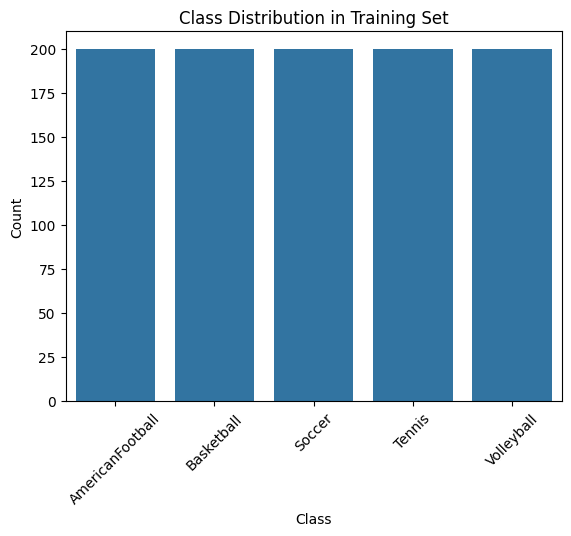


Missing values in train:
filename    0
class       0
id          0
exists      0
dtype: int64

Missing values in test:
filename    0
id          0
exists      0
dtype: int64

Sample training images:


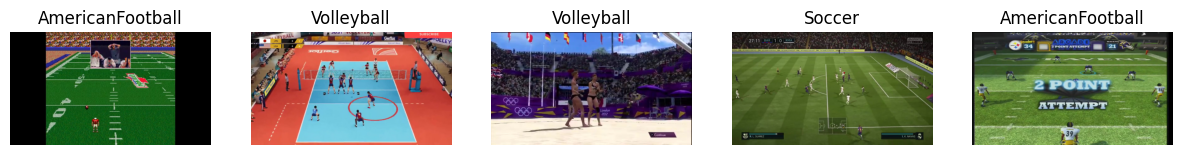


Sample test images:


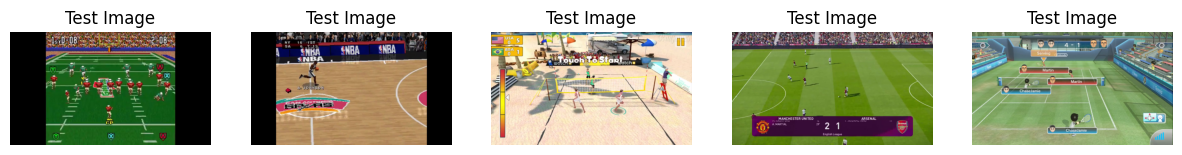

In [3]:
# Exploratory Data Analysis (EDA)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import random
import os

# Assuming train_df and test_df are already loaded from the Data Collection block

# Summary statistics for IDs
print("Train ID range:")
print(f"Min ID: {train_df['id'].min()}, Max ID: {train_df['id'].max()}")
print(f"Total training images: {len(train_df)}")

print("\nTest ID range:")
print(f"Min ID: {test_df['id'].min()}, Max ID: {test_df['id'].max()}")
print(f"Total test images: {len(test_df)}")

# Class distribution in train (since test has no classes)
if 'class' in train_df.columns:
    class_counts = Counter(train_df['class'])
    print("\nClass distribution in train:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

    # Visualize class distribution
    sns.countplot(x='class', data=train_df)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Check for missing values
print("\nMissing values in train:")
print(train_df.isnull().sum())
print("\nMissing values in test:")
print(test_df.isnull().sum())

# Updated function to display sample images with error handling
def display_sample_images(df, num_samples=5):
    sample_ids = random.sample(range(len(df)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(sample_ids):
        img_path = df.iloc[idx]['filename']
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
        else:
            axes[i].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
            print(f"Warning: Image not found at {img_path}")
        if 'class' in df.columns:
            axes[i].set_title(df.iloc[idx]['class'])
        else:
            axes[i].set_title("Test Image")
        axes[i].axis('off')
    plt.show()

print("\nSample training images:")
display_sample_images(train_df)

print("\nSample test images:")
display_sample_images(test_df)

# Data Preprocessing

In [4]:
# Data Preprocessing with Advanced Augmentation for Fine-Tuned Vision Transformer (ViT)
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, Image as HFImage, ClassLabel
from transformers import ViTImageProcessor, ViTForImageClassification
import torch
from torch.utils.data import DataLoader
from PIL import Image as PILImage
import numpy as np
from torchvision import transforms
from torchvision.transforms import functional as F
import random

# Set the main folder path
main_folder = r'D:\Rap_Gemastik2'

# Load train.csv and test.csv
train_df = pd.read_csv(os.path.join(main_folder, 'train.csv'))
test_df = pd.read_csv(os.path.join(main_folder, 'test.csv'))

# Get unique classes from train_df and create a class mapping
classes = sorted(train_df['class'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Class mapping: {class_to_idx}")

# Add labels to train_df
train_df['label'] = train_df['class'].map(class_to_idx)

# Split train_df into train and validation sets (80/20 split)
train_split, val_split = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Function to load image paths (full path)
def get_full_path(filename):
    return os.path.join(main_folder, filename)

# Prepare datasets using Hugging Face Datasets
def create_hf_dataset(df, has_labels=True):
    data = {
        'image': [get_full_path(f) for f in df['filename']],  # Store paths
    }
    if has_labels:
        data['label'] = df['label'].tolist()
    features = Features({
        'image': HFImage(),  # Will load images automatically
    })
    if has_labels:
        features['label'] = ClassLabel(names=classes)
    return Dataset.from_dict(data, features=features)

train_dataset = create_hf_dataset(train_split, has_labels=True)
val_dataset = create_hf_dataset(val_split, has_labels=True)
test_dataset = create_hf_dataset(test_df, has_labels=False)

# Combine into DatasetDict
datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Load ViT Image Processor
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)

# Advanced Augmentation with CutMix, MixUp, Noise, and Enhanced Transformations
class CutMixAugmentation:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, images, labels):
        batch_size = len(images)
        if batch_size == 0:
            return images, labels

        # Convert PIL Images to NumPy arrays
        images_np = [np.array(img) for img in images]
        lam = np.random.beta(self.alpha, self.alpha)
        rand_index = torch.randperm(batch_size).to(torch.long)

        mixed_images = images_np.copy()

        for i in range(batch_size):
            j = rand_index[i]
            bbx1, bby1, bbx2, bby2 = self._rand_bbox(224, 224, lam)
            mixed_images[i][bby1:bby2, bbx1:bbx2, :] = images_np[j][bby1:bby2, bbx1:bbx2, :]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (224 * 224))

        # Convert back to PIL Images
        mixed_images = [PILImage.fromarray(img.astype(np.uint8)) for img in mixed_images]

        # Mix and round labels to nearest integer
        mixed_labels = []
        for i in range(batch_size):
            j = rand_index[i]
            mixed_label = lam * labels[i] + (1 - lam) * labels[j]
            mixed_labels.append(np.round(mixed_label).astype(int))
        return mixed_images, mixed_labels

    def _rand_bbox(self, height, width, lam):
        cut_rat = np.sqrt(1.0 - lam)
        cut_w = int(width * cut_rat)
        cut_h = int(height * cut_rat)

        cx = np.random.randint(width)
        cy = np.random.randint(height)

        bbx1 = np.clip(cx - cut_w // 2, 0, width)
        bby1 = np.clip(cy - cut_h // 2, 0, height)
        bbx2 = np.clip(cx + cut_w // 2, 0, width)
        bby2 = np.clip(cy + cut_h // 2, 0, height)

        return bbx1, bby1, bbx2, bby2

class MixUpAugmentation:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def __call__(self, images, labels):
        batch_size = len(images)
        if batch_size == 0:
            return images, labels

        lam = np.random.beta(self.alpha, self.alpha)
        rand_index = torch.randperm(batch_size).to(torch.long)

        mixed_images = []
        mixed_labels = []
        for i in range(batch_size):
            j = rand_index[i]
            image1 = np.array(images[i])
            image2 = np.array(images[j])
            mixed_image = lam * image1 + (1 - lam) * image2
            mixed_images.append(PILImage.fromarray(mixed_image.astype(np.uint8)))
            mixed_label = lam * labels[i] + (1 - lam) * labels[j]
            mixed_labels.append(np.round(mixed_label).astype(int))
        return mixed_images, mixed_labels

# Enhanced RandAugment with Noise and Geometric Distortion
def rand_augment(image):
    # Initial resize to lower resolution (e.g., 128x128) then upscale to 224x224
    image = F.resize(image, (128, 128))
    image = F.resize(image, (224, 224))  # Upscale back with potential loss of detail

    # Define bounding box cropping
    width, height = image.size
    crop_x1 = random.randint(0, int(width * 0.3))  # Increased crop margin to 30%
    crop_y1 = random.randint(0, int(height * 0.3))
    crop_x2 = width - random.randint(0, int(width * 0.3))
    crop_y2 = height - random.randint(0, int(height * 0.3))
    image = F.crop(image, crop_y1, crop_x1, crop_y2 - crop_y1, crop_x2 - crop_x1)
    image = F.resize(image, (224, 224))

    # Apply enhanced jittering and other augmentations
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(45),  # Increased to 45 degrees
        transforms.ColorJitter(brightness=(0.2, 1.2), contrast=(0.2, 1.7), saturation=(0.2, 1.7), hue=0.15),  # Wider range
        transforms.RandomAffine(degrees=10, translate=(0.3, 0.3), scale=(0.7, 1.3), shear=10),  # Added shear
        transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 1.0))  # Increased blur
    ])

    # Add Gaussian noise
    image_np = np.array(image) / 255.0
    noise = np.random.normal(0, 0.1, image_np.shape)  # Noise with mean=0, std=0.1
    image_np = np.clip(image_np + noise, 0, 1)
    image = PILImage.fromarray((image_np * 255).astype(np.uint8))

    return augmentations(image)

# Preprocessing with augmentations
def preprocess(examples, is_train=True):
    images = examples['image']
    if is_train:
        # Apply initial augmentations
        images = [rand_augment(img) for img in images]
        # Apply CutMix or MixUp randomly
        if random.random() > 0.5:  # 50% chance for CutMix
            cutmix = CutMixAugmentation(alpha=1.0)
            images, labels = cutmix(images, examples['label'])
        else:  # 50% chance for MixUp
            mixup = MixUpAugmentation(alpha=1.0)
            images, labels = mixup(images, examples['label'])
        # Convert to tensor and normalize
        images = [F.to_tensor(img) for img in images]
        images = torch.stack(images)
        examples['pixel_values'] = images
        examples['label'] = torch.tensor(labels, dtype=torch.long)
    else:
        images = [F.resize(img, (224, 224)) for img in images]  # Consistent resize for validation/test
        images = [F.to_tensor(img) for img in images]
        images = torch.stack(images)
        examples['pixel_values'] = images
    del examples['image']
    return examples

# Apply preprocessing
datasets['train'] = datasets['train'].map(lambda x: preprocess(x, is_train=True), batched=True, batch_size=32)
datasets['validation'] = datasets['validation'].map(lambda x: preprocess(x, is_train=False), batched=True, batch_size=32)
datasets['test'] = datasets['test'].map(lambda x: preprocess(x, is_train=False), batched=True, batch_size=32)

# Set format for PyTorch
datasets['train'].set_format(type='torch', columns=['pixel_values', 'label'])
datasets['validation'].set_format(type='torch', columns=['pixel_values', 'label'])
datasets['test'].set_format(type='torch', columns=['pixel_values'])

# Create DataLoaders
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    if 'label' in batch[0]:
        labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
        return {'pixel_values': pixel_values, 'labels': labels}
    return {'pixel_values': pixel_values}

train_loader = DataLoader(datasets['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(datasets['validation'], batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(datasets['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)

print("Data preprocessing with augmentation completed.")
print(f"Train loader size: {len(train_loader)} batches")
print(f"Validation loader size: {len(val_loader)} batches")
print(f"Test loader size: {len(test_loader)} batches")

# Load the model for fine-tuning
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)

Classes: ['AmericanFootball', 'Basketball', 'Soccer', 'Tennis', 'Volleyball']
Class mapping: {'AmericanFootball': 0, 'Basketball': 1, 'Soccer': 2, 'Tennis': 3, 'Volleyball': 4}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: de52ea17-c56d-4bf7-b0f9-a8a9016ef7d6)')' thrown while requesting HEAD https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/processor_config.json
Retrying in 1s [Retry 1/5].


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Data preprocessing with augmentation completed.
Train loader size: 50 batches
Validation loader size: 13 batches
Test loader size: 9 batches


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Fine-Tuning

In [7]:
from sklearn.model_selection import KFold
import torch
from torch.optim import AdamW
from transformers import ViTForImageClassification
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import torch.nn.functional as nnF
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datasets import DatasetDict

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU.")

# Define hyperparameters
learning_rate = 1e-5
num_epochs = 15
batch_size = 16

# Custom loss with label smoothing
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, target):
        log_prob = nnF.log_softmax(input, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Define training and evaluation functions
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(val_loader), accuracy

def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Prediction"):
            pixel_values = batch['pixel_values'].to(device)
            outputs = model(pixel_values=pixel_values)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

# Define K-Fold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare full dataset
full_dataset = create_hf_dataset(train_df, has_labels=True)

# Store results
fold_results = []

# Modifikasi loop K-Fold
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_dataset)))):
    print(f"\nFold {fold + 1}/{k_folds}")
    
    # Create fold datasets
    train_dataset = full_dataset.select(train_idx)
    val_dataset = full_dataset.select(val_idx)
    
    # Combine into DatasetDict for this fold
    datasets = DatasetDict({
        'train': train_dataset,
        'validation': val_dataset,
        'test': test_dataset
    })

    # Apply preprocessing with adjusted augmentations
    datasets['train'] = datasets['train'].map(lambda x: preprocess(x, is_train=True), batched=True, batch_size=32)
    datasets['validation'] = datasets['validation'].map(lambda x: preprocess(x, is_train=False), batched=True, batch_size=32)
    datasets['test'] = datasets['test'].map(lambda x: preprocess(x, is_train=False), batched=True, batch_size=32)

    # Set format
    datasets['train'].set_format(type='torch', columns=['pixel_values', 'label'])
    datasets['validation'].set_format(type='torch', columns=['pixel_values', 'label'])
    datasets['test'].set_format(type='torch', columns=['pixel_values'])

    # Create DataLoaders
    train_loader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    print(f"Train samples: {len(datasets['train'])}, Val samples: {len(datasets['validation'])}")

    # Fine-tune model for this fold
    model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Tingkatkan regularisasi
    criterion = LabelSmoothingLoss(smoothing=0.1)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    best_val_loss = float('inf')
    patience = 7
    trigger_times = 0

    # Define history
    history = {
        'fold': [],
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = evaluate(model, val_loader, device)
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.save_pretrained(os.path.join(main_folder, f"best_vit_model_fold{fold}"))
            print("Saved best model")
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

        # Simpan history
        history['fold'].append(fold + 1)
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Update scheduler
        scheduler.step(val_loss)

    fold_results.append((best_val_loss, val_accuracy))

# Average results across folds
avg_loss = np.mean([r[0] for r in fold_results])
avg_accuracy = np.mean([r[1] for r in fold_results])
print(f"\nAverage Validation Loss across {k_folds} folds: {avg_loss:.4f}")
print(f"Average Validation Accuracy across {k_folds} folds: {avg_accuracy:.4f}")

# Use the best model from the last fold for test prediction
model = ViTForImageClassification.from_pretrained(os.path.join(main_folder, f"best_vit_model_fold{fold}")).to(device)
test_preds = predict(model, test_loader, device)
predicted_classes = [classes[pred] for pred in test_preds]
test_df['predicted_class'] = predicted_classes
test_df.to_csv(os.path.join(main_folder, 'test_predictions.csv'), index=False)
print("Predictions saved to test_predictions.csv")

Using GPU: NVIDIA GeForce RTX 4070 Laptop GPU

Fold 1/5


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Train samples: 800, Val samples: 200


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.97it/s]


Train Loss: 1.5615, Validation Loss: 1.5754, Accuracy: 0.3500
Saved best model
Epoch 2/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.89it/s]


Train Loss: 1.3761, Validation Loss: 1.5269, Accuracy: 0.5700
Saved best model
Epoch 3/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.57it/s]


Train Loss: 1.1473, Validation Loss: 1.4489, Accuracy: 0.6900
Saved best model
Epoch 4/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.63it/s]


Train Loss: 0.9352, Validation Loss: 1.3850, Accuracy: 0.7650
Saved best model
Epoch 5/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.74it/s]


Train Loss: 0.7596, Validation Loss: 1.2811, Accuracy: 0.8050
Saved best model
Epoch 6/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.21it/s]


Train Loss: 0.6236, Validation Loss: 1.1886, Accuracy: 0.8400
Saved best model
Epoch 7/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.16it/s]


Train Loss: 0.5291, Validation Loss: 1.0953, Accuracy: 0.8750
Saved best model
Epoch 8/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.18it/s]


Train Loss: 0.4711, Validation Loss: 1.0004, Accuracy: 0.8550
Saved best model
Epoch 9/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]


Train Loss: 0.4376, Validation Loss: 0.9319, Accuracy: 0.8900
Saved best model
Epoch 10/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.57it/s]


Train Loss: 0.4197, Validation Loss: 0.9082, Accuracy: 0.9050
Saved best model
Epoch 11/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.73it/s]


Train Loss: 0.4099, Validation Loss: 0.8632, Accuracy: 0.9100
Saved best model
Epoch 12/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.47it/s]


Train Loss: 0.4035, Validation Loss: 0.8430, Accuracy: 0.8950
Saved best model
Epoch 13/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.58it/s]


Train Loss: 0.3977, Validation Loss: 0.8160, Accuracy: 0.9250
Saved best model
Epoch 14/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.55it/s]


Train Loss: 0.3953, Validation Loss: 0.7929, Accuracy: 0.9200
Saved best model
Epoch 15/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.70it/s]


Train Loss: 0.3937, Validation Loss: 0.7822, Accuracy: 0.9250
Saved best model

Fold 2/5


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Train samples: 800, Val samples: 200


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.24it/s]


Train Loss: 1.5508, Validation Loss: 1.5903, Accuracy: 0.2400
Saved best model
Epoch 2/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.66it/s]


Train Loss: 1.3707, Validation Loss: 1.5535, Accuracy: 0.3600
Saved best model
Epoch 3/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.30it/s]


Train Loss: 1.1586, Validation Loss: 1.5058, Accuracy: 0.4550
Saved best model
Epoch 4/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.69it/s]


Train Loss: 0.9397, Validation Loss: 1.4388, Accuracy: 0.5500
Saved best model
Epoch 5/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.44it/s]


Train Loss: 0.7464, Validation Loss: 1.3724, Accuracy: 0.5650
Saved best model
Epoch 6/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.86it/s]


Train Loss: 0.6020, Validation Loss: 1.3015, Accuracy: 0.5950
Saved best model
Epoch 7/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.19it/s]


Train Loss: 0.5072, Validation Loss: 1.2295, Accuracy: 0.6300
Saved best model
Epoch 8/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.14it/s]


Train Loss: 0.4547, Validation Loss: 1.1980, Accuracy: 0.5850
Saved best model
Epoch 9/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.53it/s]


Train Loss: 0.4264, Validation Loss: 1.1662, Accuracy: 0.5900
Saved best model
Epoch 10/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.43it/s]


Train Loss: 0.4110, Validation Loss: 1.1348, Accuracy: 0.5950
Saved best model
Epoch 11/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.98it/s]


Train Loss: 0.4032, Validation Loss: 1.1147, Accuracy: 0.6150
Saved best model
Epoch 12/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.42it/s]


Train Loss: 0.3989, Validation Loss: 1.1011, Accuracy: 0.6000
Saved best model
Epoch 13/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.34it/s]


Train Loss: 0.3959, Validation Loss: 1.0825, Accuracy: 0.6100
Saved best model
Epoch 14/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.34it/s]


Train Loss: 0.3941, Validation Loss: 1.0790, Accuracy: 0.6000
Saved best model
Epoch 15/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.26it/s]


Train Loss: 0.3929, Validation Loss: 1.0774, Accuracy: 0.5950
Saved best model

Fold 3/5


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Train samples: 800, Val samples: 200


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.32it/s]


Train Loss: 1.5735, Validation Loss: 1.5871, Accuracy: 0.2450
Saved best model
Epoch 2/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.30it/s]


Train Loss: 1.3960, Validation Loss: 1.5312, Accuracy: 0.4850
Saved best model
Epoch 3/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.37it/s]


Train Loss: 1.1763, Validation Loss: 1.4564, Accuracy: 0.6700
Saved best model
Epoch 4/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.50it/s]


Train Loss: 0.9493, Validation Loss: 1.3606, Accuracy: 0.7700
Saved best model
Epoch 5/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.87it/s]


Train Loss: 0.7557, Validation Loss: 1.2599, Accuracy: 0.8500
Saved best model
Epoch 6/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.68it/s]


Train Loss: 0.6150, Validation Loss: 1.1579, Accuracy: 0.8800
Saved best model
Epoch 7/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.46it/s]


Train Loss: 0.5188, Validation Loss: 1.0526, Accuracy: 0.9050
Saved best model
Epoch 8/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.52it/s]


Train Loss: 0.4603, Validation Loss: 0.9838, Accuracy: 0.9000
Saved best model
Epoch 9/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.66it/s]


Train Loss: 0.4294, Validation Loss: 0.9069, Accuracy: 0.9200
Saved best model
Epoch 10/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.49it/s]


Train Loss: 0.4127, Validation Loss: 0.8669, Accuracy: 0.9250
Saved best model
Epoch 11/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.47it/s]


Train Loss: 0.4044, Validation Loss: 0.8367, Accuracy: 0.9250
Saved best model
Epoch 12/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.51it/s]


Train Loss: 0.3998, Validation Loss: 0.8105, Accuracy: 0.9250
Saved best model
Epoch 13/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.47it/s]


Train Loss: 0.3968, Validation Loss: 0.7944, Accuracy: 0.9200
Saved best model
Epoch 14/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.43it/s]


Train Loss: 0.3949, Validation Loss: 0.7771, Accuracy: 0.9200
Saved best model
Epoch 15/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.49it/s]


Train Loss: 0.3935, Validation Loss: 0.7700, Accuracy: 0.9250
Saved best model

Fold 4/5


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Train samples: 800, Val samples: 200


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.61it/s]


Train Loss: 1.5607, Validation Loss: 1.5676, Accuracy: 0.3650
Saved best model
Epoch 2/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.64it/s]


Train Loss: 1.3901, Validation Loss: 1.5223, Accuracy: 0.4850
Saved best model
Epoch 3/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.63it/s]


Train Loss: 1.1878, Validation Loss: 1.4620, Accuracy: 0.6550
Saved best model
Epoch 4/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.57it/s]


Train Loss: 0.9844, Validation Loss: 1.3954, Accuracy: 0.7850
Saved best model
Epoch 5/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]


Train Loss: 0.7954, Validation Loss: 1.3181, Accuracy: 0.8400
Saved best model
Epoch 6/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.39it/s]


Train Loss: 0.6351, Validation Loss: 1.2257, Accuracy: 0.8350
Saved best model
Epoch 7/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.79it/s]


Train Loss: 0.5203, Validation Loss: 1.1226, Accuracy: 0.8550
Saved best model
Epoch 8/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.46it/s]


Train Loss: 0.4549, Validation Loss: 1.0375, Accuracy: 0.8600
Saved best model
Epoch 9/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]


Train Loss: 0.4230, Validation Loss: 0.9821, Accuracy: 0.8650
Saved best model
Epoch 10/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.57it/s]


Train Loss: 0.4091, Validation Loss: 0.9405, Accuracy: 0.8500
Saved best model
Epoch 11/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.57it/s]


Train Loss: 0.4020, Validation Loss: 0.9098, Accuracy: 0.8450
Saved best model
Epoch 12/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.44it/s]


Train Loss: 0.3979, Validation Loss: 0.8856, Accuracy: 0.8450
Saved best model
Epoch 13/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.56it/s]


Train Loss: 0.3954, Validation Loss: 0.8715, Accuracy: 0.8400
Saved best model
Epoch 14/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.55it/s]


Train Loss: 0.3937, Validation Loss: 0.8568, Accuracy: 0.8400
Saved best model
Epoch 15/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.64it/s]


Train Loss: 0.3926, Validation Loss: 0.8470, Accuracy: 0.8400
Saved best model

Fold 5/5


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Train samples: 800, Val samples: 200


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Rap_Gemastik2\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.54it/s]


Train Loss: 1.5479, Validation Loss: 1.5543, Accuracy: 0.5050
Saved best model
Epoch 2/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.66it/s]


Train Loss: 1.3397, Validation Loss: 1.5004, Accuracy: 0.4900
Saved best model
Epoch 3/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.60it/s]


Train Loss: 1.1015, Validation Loss: 1.4353, Accuracy: 0.5000
Saved best model
Epoch 4/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.66it/s]


Train Loss: 0.8729, Validation Loss: 1.3521, Accuracy: 0.5750
Saved best model
Epoch 5/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.71it/s]


Train Loss: 0.6847, Validation Loss: 1.2651, Accuracy: 0.6400
Saved best model
Epoch 6/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.45it/s]


Train Loss: 0.5602, Validation Loss: 1.1816, Accuracy: 0.6950
Saved best model
Epoch 7/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.41it/s]


Train Loss: 0.4794, Validation Loss: 1.1116, Accuracy: 0.7100
Saved best model
Epoch 8/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.54it/s]


Train Loss: 0.4396, Validation Loss: 1.0632, Accuracy: 0.7000
Saved best model
Epoch 9/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.54it/s]


Train Loss: 0.4171, Validation Loss: 1.0217, Accuracy: 0.7150
Saved best model
Epoch 10/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.32it/s]


Train Loss: 0.4059, Validation Loss: 0.9841, Accuracy: 0.7150
Saved best model
Epoch 11/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.61it/s]


Train Loss: 0.4001, Validation Loss: 0.9668, Accuracy: 0.7150
Saved best model
Epoch 12/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.49it/s]


Train Loss: 0.3967, Validation Loss: 0.9534, Accuracy: 0.7400
Saved best model
Epoch 13/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.48it/s]


Train Loss: 0.3946, Validation Loss: 0.9331, Accuracy: 0.7400
Saved best model
Epoch 14/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.69it/s]


Train Loss: 0.3932, Validation Loss: 0.9280, Accuracy: 0.7450
Saved best model
Epoch 15/15


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.54it/s]


Train Loss: 0.3923, Validation Loss: 0.9128, Accuracy: 0.7500
Saved best model

Average Validation Loss across 5 folds: 0.8779
Average Validation Accuracy across 5 folds: 0.8070


Prediction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.91it/s]

Predictions saved to test_predictions.csv


# Evaluation


Loss History (Tabular Text):
+--------+---------+--------------+------------+
|   Fold |   Epoch |   Train Loss |   Val Loss |
+========+=========+==============+============+
|      5 |       1 |       1.5479 |     1.5543 |
+--------+---------+--------------+------------+
|      5 |       2 |       1.3397 |     1.5004 |
+--------+---------+--------------+------------+
|      5 |       3 |       1.1015 |     1.4353 |
+--------+---------+--------------+------------+
|      5 |       4 |       0.8729 |     1.3521 |
+--------+---------+--------------+------------+
|      5 |       5 |       0.6847 |     1.2651 |
+--------+---------+--------------+------------+
|      5 |       6 |       0.5602 |     1.1816 |
+--------+---------+--------------+------------+
|      5 |       7 |       0.4794 |     1.1116 |
+--------+---------+--------------+------------+
|      5 |       8 |       0.4396 |     1.0632 |
+--------+---------+--------------+------------+
|      5 |       9 |       0.4171 |    

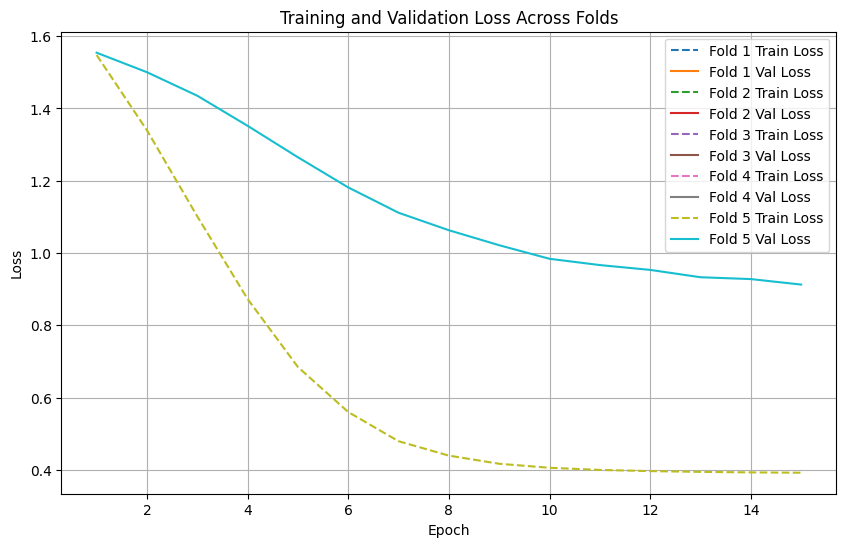


Metrics History (Tabular Text):
+--------+---------+------------+
|   Fold |   Epoch |   Accuracy |
+========+=========+============+
|      5 |       1 |      0.505 |
+--------+---------+------------+
|      5 |       2 |      0.49  |
+--------+---------+------------+
|      5 |       3 |      0.5   |
+--------+---------+------------+
|      5 |       4 |      0.575 |
+--------+---------+------------+
|      5 |       5 |      0.64  |
+--------+---------+------------+
|      5 |       6 |      0.695 |
+--------+---------+------------+
|      5 |       7 |      0.71  |
+--------+---------+------------+
|      5 |       8 |      0.7   |
+--------+---------+------------+
|      5 |       9 |      0.715 |
+--------+---------+------------+
|      5 |      10 |      0.715 |
+--------+---------+------------+
|      5 |      11 |      0.715 |
+--------+---------+------------+
|      5 |      12 |      0.74  |
+--------+---------+------------+
|      5 |      13 |      0.74  |
+--------+-----

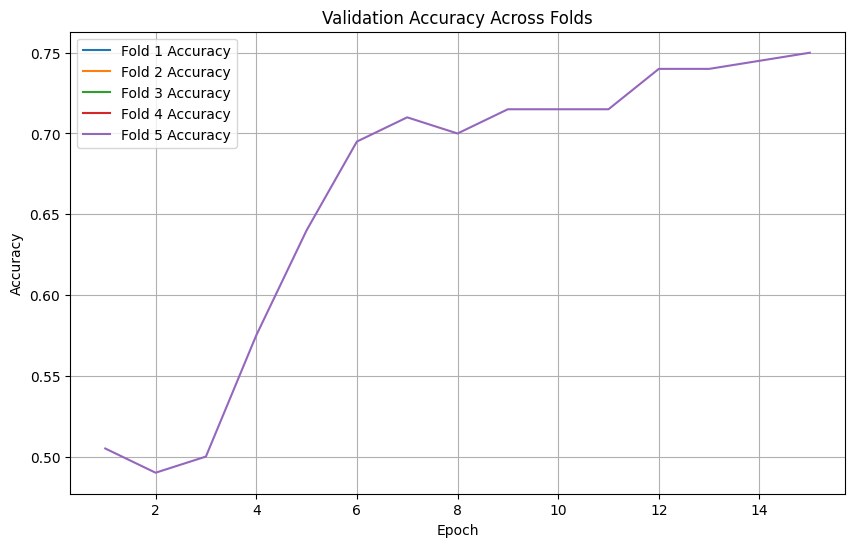

In [12]:
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pastikan semua dependensi diimpor dan variabel (history, k_folds, classes, device, model, test_loader, test_df, train_df) sudah didefinisikan

# Visualisasi Tabular Text untuk Loss
print("\nLoss History (Tabular Text):")
loss_table = []
for i in range(len(history['fold'])):
    loss_table.append([
        history['fold'][i],
        history['epoch'][i],
        f"{history['train_loss'][i]:.4f}",
        f"{history['val_loss'][i]:.4f}"
    ])
print(tabulate(loss_table, headers=["Fold", "Epoch", "Train Loss", "Val Loss"], tablefmt="grid"))

# Visualisasi Grafik untuk Loss
plt.figure(figsize=(10, 6))
for fold in range(1, k_folds + 1):
    fold_mask = [i for i, f in enumerate(history['fold']) if f == fold]
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['train_loss'][i] for i in fold_mask],
             label=f'Fold {fold} Train Loss', linestyle='--')
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['val_loss'][i] for i in fold_mask],
             label=f'Fold {fold} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Visualisasi Tabular Text untuk Metrik
print("\nMetrics History (Tabular Text):")
metrics_table = []
for i in range(len(history['fold'])):
    metrics_table.append([
        history['fold'][i],
        history['epoch'][i],
        f"{history['val_accuracy'][i]:.4f}"
    ])
print(tabulate(metrics_table, headers=["Fold", "Epoch", "Accuracy"], tablefmt="grid"))

# Visualisasi Grafik untuk Metrik
plt.figure(figsize=(10, 6))
for fold in range(1, k_folds + 1):
    fold_mask = [i for i, f in enumerate(history['fold']) if f == fold]
    plt.plot([history['epoch'][i] for i in fold_mask],
             [history['val_accuracy'][i] for i in fold_mask],
             label=f'Fold {fold} Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Submission

In [13]:
# Generate Submission File
import pandas as pd
import os

# Use the best model from the last fold for test prediction (already done in training block)
# Assuming test_preds is available from the training block

# Map predictions back to class names
predicted_classes = [classes[pred] for pred in test_preds]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'class': predicted_classes
})

# Save to CSV
submission_df.to_csv(os.path.join(main_folder, 'submission.csv'), index=False)
print("Submission file saved to submission.csv")

Submission file saved to submission.csv
